# Checkerboard Microstructure

## Introduction - What are 2-Point Spatial Correlations (also called 2-Point Statistics)?

The purpose of this example is to introduce 2-point spatial correlations and how they are computed, using PyMKS.

The example starts with some introductory information about spatial correlations. PyMKS is used to compute both the periodic and non-periodic 2-point spatial correlations (also referred to as 2-point statistics or autocorrelations and crosscorrelations) for a checkerboard microstructure. This is a relatively simple example that allows an easy discussion of how the spatial correlations capture the main features seen in the original microstructure. If you would like more technical details about 2-point statistics please see the [theory section](../../THEORY.html).

In [1]:
#NBVAL_IGNORE_OUTPUT

#from __future__ import print_function
#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from numpy import allclose
from pymks.fmks.data.checkerboard import generate
from pymks.fmks.plot import plot_microstructures
from sklearn.pipeline import Pipeline
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointcorrelation

## 2-Point Statistics for Checkerboard Microstructure

Let's first start with making a microstructure that looks like a 8 x 8 checkerboard. Although this type of microstructure may not resemble a physical system, it provides solutions that give some intuitive understanding of 2-point statistics.

We can create a checkerboard microstructure using `make_checkerboard_microstructure` function from `pymks.datasets`.

In [2]:
x_data = generate((21 * 8, 21 * 8), (21, 21))

Now let's take a look at how the microstructure looks.

(1, 168, 168)


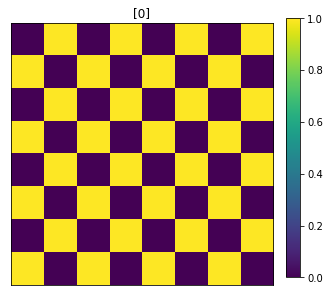

In [5]:
plot_microstructures(x_data[0], titles=['[0]'])
print(x_data.shape)

## Compute Periodic 2-Point Statistics

Now that we have created a microstructure to work with, we can start computing the 2-point statistics. Let's start by looking at the periodic autocorrelations of the microstructure and then compute the periodic crosscorrelation. This can be done using the `autocorrelate` and `crosscorrelate` functions from `pymks.states`, and using the keyword argument `periodic_axes` to specify the axes that are periodic. 

In order to compute 2-pont statistics, we need to select a basis to generate the microstructure function `X_` from the microstructure `X`. Because we only have values of 0 or 1 in our microstructure we will using the `PrimitiveBasis` with `n_states` equal to 2.

In [4]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointcorrelation(periodic_boundary=True, cutoff=x_data.shape[1]))
])

x_auto = model.transform(x_data).compute() 
x_auto.shape

(1, 84, 84, 2)

We have now computed the autocorrelations.

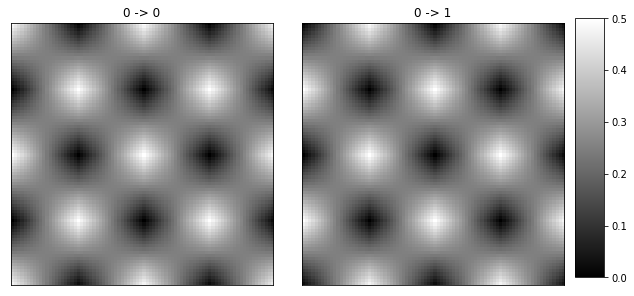

In [55]:
plot_microstructures(x_auto[0, :, :, 0], x_auto[0, :, :, 1], titles=['0 -> 0', '0 -> 1'], cmap='gray')

Notice that for this checkerboard microstructure, the correlations are offset, but with the same values. We have just computed the periodic autocorrelations for a perfectly periodic microstructure with equal volume fractions. In general this is not the case and the autocorrelations will be different, as we will see later in this example.

As mentioned in the introduction, because we using an indicator basis and are using eigen microstructure functions (values are either 0 or 1), then the (0, 0) vector equals the volume fraction for an autocorrelation.

Notice that the crosscorrelation is the exact opposite of the autocorrelation. The (0, 0) vector has a value of 0. This statistic reflects the probablity of 2 phases having the same location. In our microstructure, this probability is zero, as we have not allowed the two phases (colored black and white) to co-exist in the same spatial voxel.

Let's double check the center points have the correct values.

In [56]:
center = (x_auto.shape[1] + 1) // 2
print('Volume fraction of 0 -> 0: ', allclose(x_auto[0, center, center, 0], 0.5))
print('Volume fraction of 0 -> 1: ', allclose(x_auto[0, center, center, 1], 0))


Volume fraction of 0 -> 0:  True
Volume fraction of 0 -> 1:  True


## Compute Non-Periodic 2-Point Statistics

We will now compute the non-periodic 2-point statistics for our microstructure. This time, rather than using the `autocorrelate` and `crosscorrelate` functions, we will use the `correlate` function from `pymks.stats`. The `correlate` function computes all of the autocorrelations and crosscorrelations at the same time. We will compute the non-periodic statistics by omitting the keyword argument `periodic_axes`.

In [6]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('correlations', TwoPointcorrelation(periodic_boundary=False, cutoff=x_data.shape[1]))
])

x_auto = model.transform(x_data).compute() 
x_auto.shape

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'

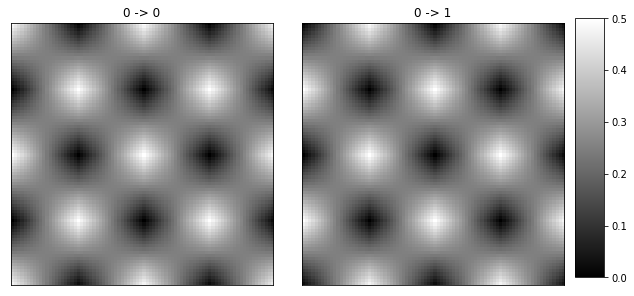

In [58]:
plot_microstructures(x_auto[0, :, :, 0], x_auto[0, :, :, 1], titles=['0 -> 0', '0 -> 1'], cmap='gray')

All or some of the correlations can be viewed, using the `draw_correlations` function from `pymks.tools`. In this example we will look at all of them.

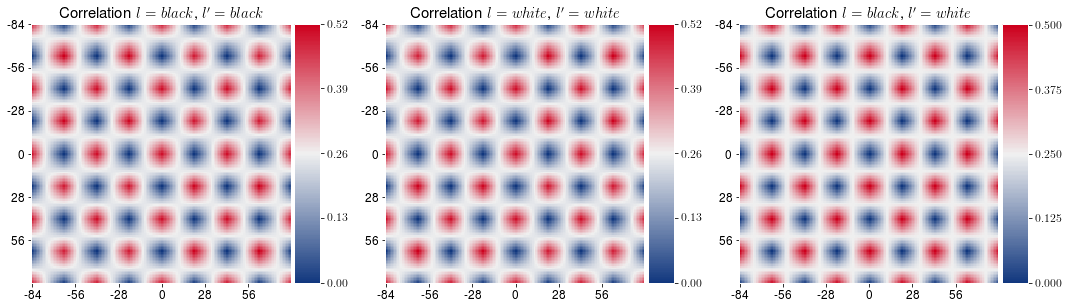

In [12]:
from pymks.tools import draw_correlations

correlations = [('black', 'black'), ('white', 'white'), ('black', 'white')]
draw_correlations(X_corr[0].real, correlations=correlations)


Notice that the maximum values for the autocorrelations are higher than 0.5. We can still show that the centers or the (0, 0) vectors are still equal to the volume fractions.

In [13]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print('Volume fraction of black phase', X_corr[0, center, center, 0])
print('Volume fraction of white phase', X_corr[0, center, center, 1])

Volume fraction of black phase 0.5
Volume fraction of white phase 0.5


The non-periodic statistics are different from the periodic 2-point statistics along the diagonal vectors, but in both cases the probability of (0, 0) vector is still the volume fraction.

## References

[1] S.R. Niezgoda, D.T. Fullwood, S.R. Kalidindi, Delineation of the Space of 2-Point Correlations in a Composite Material System, Acta Materialia, 56, 18, 2008, 5285–5292 [doi:10.1016/j.actamat.2008.07.005](http://dx.doi.org/10.1016/j.actamat.2008.07.005)

 
[2] S.R. Niezgoda, D.M. Turner, D.T. Fullwood, S.R. Kalidindi, Optimized Structure Based Representative Volume Element Sets Reflecting the Ensemble-Averaged 2-Point Statistics, 58, 13, 2010, 4432–4445  [doi:10.1016/j.actamat.2010.04.041](http://dx.doi.org/10.1016/j.actamat.2010.04.041)


[3] D.T. Fullwood, S.R. Kalidindi, and B.L. Adams, Second - Order Microstructure Sensitive Design Using 2-Point Spatial  Correlations, Chapter 12 in Electron Backscatter Diffraction in Materials Science , 2nd Edition , Eds. A. Schwartz, M. Kumar, B. Adams, D. Field, Springer, NY, 2009. 